# PREDICTING RENEWABLE ENERGY OUTPUT AND CONSUMPTION

by Héctor Ramírez

<hr>

# Conclusions & thoughts

<ul>
    <li> It seems to me that by lagging variables one only creates new features, <i>i.e.</i>, there is little difference in extending the dataset to (t-x) for x>>1 when predicting only the next hour (with 2 or 3 lagged features is enough). <br><br>
    <li> Shuffling the dataset gives better results despite the strong arguments not in favor of it when using LSTM networks. <a href='https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/'> Machine Learning Mastery</a> somewhere mentions that when this happens, different kind of convolutional NN should be used. I wonder if this is because of the volatile nature of this time series.<br><br>
        Furthermore, the results seem to vary considerably for different shuffled sets. Namely, it is possible that one needs to repeate the full process several times shuffling the data each time and obtain an average RMSE of the averaged one obtained from the reapeated trainnings of the LSTM network. <br><br>
    <li> Given the shape needed for the LSTM inputs, no $var(t)$ features are used (they are dropped). They might be useful if there's a way to include them. <br><br>
    <li> Usually, the model accuracy is a useful discriminator of the model performance, and the mean directional accuracy is for time series. Both are very poor in this experiment. <br><br>
    <li> The XGBoost model is not very different. This could hint that the LSTM is again not very efficient.
</ul>
<hr>
<hr>

## Data Preparation

Very similar to the Google Colab file.

In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
warnings.filterwarnings('ignore')

In [2]:
# My files locally
files_path = "/Users/hramirez/GitHub/Renewable_Energy/files/"

Meteo = pd.read_csv(files_path + "Meteo.csv", parse_dates=[['Date', 'Time']])
datos_solar = pd.read_excel(files_path + "Datos_solar_y_demanda_residencial.xlsx")
Meteo.head()

,Date_Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,UV,Solar
0,2015-01-01 01:01:00,31.5 F,23.2 F,71 %,West,0.0 mph,2.2 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²
1,2015-01-01 01:08:00,31.2 F,22.9 F,71 %,West,0.0 mph,1.2 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²
2,2015-01-01 01:11:00,30.6 F,22.3 F,71 %,West,0.0 mph,1.6 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²
3,2015-01-01 01:16:00,30.4 F,22.1 F,71 %,WNW,0.0 mph,1.6 mph,29.86 in,0.00 in,0.00 in,NaN,w/m²
4,2015-01-01 01:21:00,30.0 F,21.8 F,71 %,NW,0.0 mph,1.6 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²


In [3]:
datos_solar.head()

,Date,PV Tejado (W),PV2 Parque (W),Demanda (W)
0,2015-01-01 00:00:00,0,0,146
1,2015-01-01 01:00:00,0,0,262
2,2015-01-01 02:00:00,0,0,308
3,2015-01-01 03:00:00,0,0,954
4,2015-01-01 04:00:00,0,0,1424


In [4]:
# Transform times

def round_to_5min(t):
    delta = datetime.timedelta(minutes=t.minute % 5,
                               seconds=t.second,
                               microseconds=t.microsecond)
    t -= delta
    if delta > datetime.timedelta(0):
        t += datetime.timedelta(minutes=5)
    return t


Meteo['DateRound'] = Meteo["Date_Time"].dt.round("5min")
datos_solar['DateRound'] = datos_solar['Date'].dt.round("5min")

Meteo['Hour'] = Meteo['DateRound'].dt.hour
Meteo['Day'] = Meteo['DateRound'].dt.dayofyear
Meteo.head()

,Date_Time,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,UV,Solar,DateRound,Hour,Day
0,2015-01-01 01:01:00,31.5 F,23.2 F,71 %,West,0.0 mph,2.2 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²,2015-01-01 01:00:00,1,1
1,2015-01-01 01:08:00,31.2 F,22.9 F,71 %,West,0.0 mph,1.2 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²,2015-01-01 01:10:00,1,1
2,2015-01-01 01:11:00,30.6 F,22.3 F,71 %,West,0.0 mph,1.6 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²,2015-01-01 01:10:00,1,1
3,2015-01-01 01:16:00,30.4 F,22.1 F,71 %,WNW,0.0 mph,1.6 mph,29.86 in,0.00 in,0.00 in,NaN,w/m²,2015-01-01 01:15:00,1,1
4,2015-01-01 01:21:00,30.0 F,21.8 F,71 %,NW,0.0 mph,1.6 mph,29.87 in,0.00 in,0.00 in,NaN,w/m²,2015-01-01 01:20:00,1,1


In [5]:
datos_solar.head()

,Date,PV Tejado (W),PV2 Parque (W),Demanda (W),DateRound
0,2015-01-01 00:00:00,0,0,146,2015-01-01 00:00:00
1,2015-01-01 01:00:00,0,0,262,2015-01-01 01:00:00
2,2015-01-01 02:00:00,0,0,308,2015-01-01 02:00:00
3,2015-01-01 03:00:00,0,0,954,2015-01-01 03:00:00
4,2015-01-01 04:00:00,0,0,1424,2015-01-01 04:00:00


In [6]:
# Clean Meteo Frame from characters and columns that do not give information in this case: UV, Solar and Wind**

def clean(x):
    try:
        return x.str.replace(r"[a-zA-Z\%\/²]", '')
    except:
        return x


Meteo = Meteo.apply(lambda x: clean(x))
Meteo = Meteo.drop(columns=['UV', 'Solar', 'Wind'])
Meteo.head()

,Date_Time,Temperature,Dew Point,Humidity,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,DateRound,Hour,Day
0,2015-01-01 01:01:00,31.5,23.2,71,0.0,2.2,29.87,0.00,0.00,2015-01-01 01:00:00,1,1
1,2015-01-01 01:08:00,31.2,22.9,71,0.0,1.2,29.87,0.00,0.00,2015-01-01 01:10:00,1,1
2,2015-01-01 01:11:00,30.6,22.3,71,0.0,1.6,29.87,0.00,0.00,2015-01-01 01:10:00,1,1
3,2015-01-01 01:16:00,30.4,22.1,71,0.0,1.6,29.86,0.00,0.00,2015-01-01 01:15:00,1,1
4,2015-01-01 01:21:00,30.0,21.8,71,0.0,1.6,29.87,0.00,0.00,2015-01-01 01:20:00,1,1


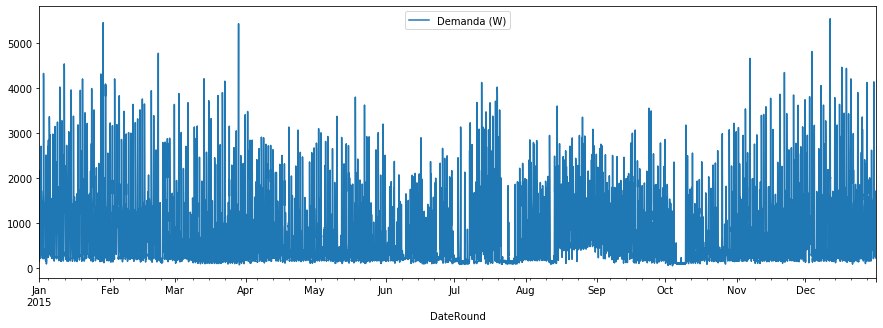

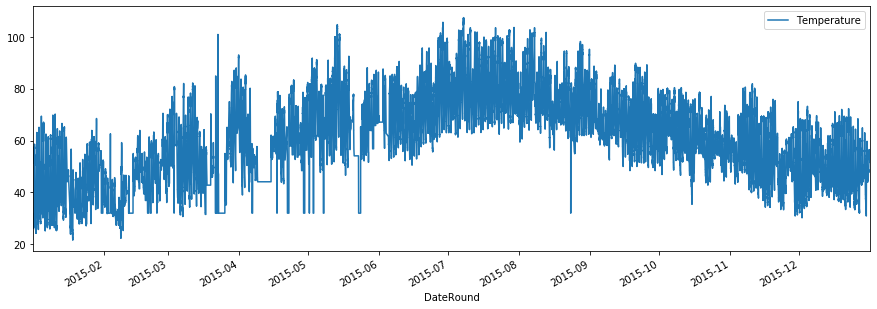

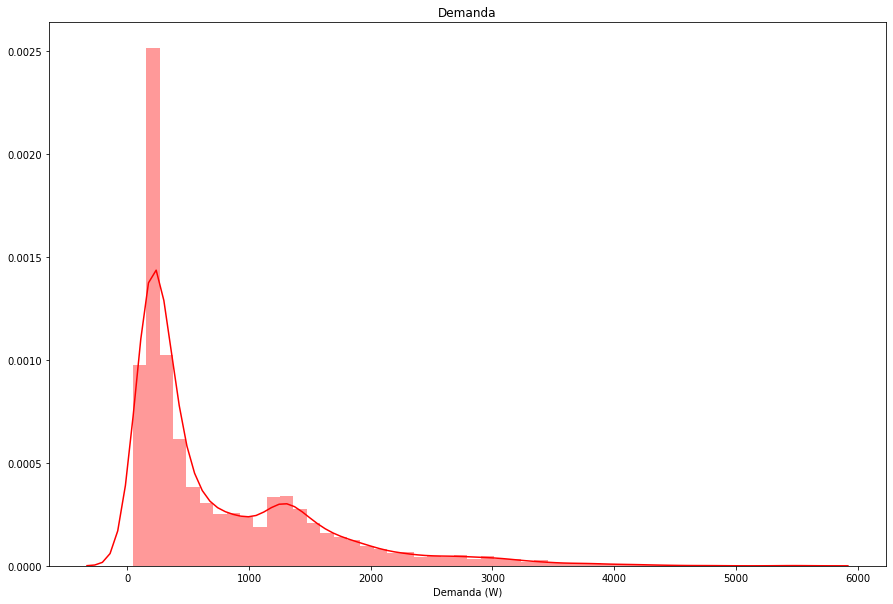

In [7]:
Meteo.Temperature = pd.to_numeric(Meteo.Temperature)
datos_solar.plot(x='DateRound', y='Demanda (W)', figsize=(15,5))
Meteo.plot(x='DateRound', y='Temperature', figsize=(15,5)) 

plt.figure(figsize=(15,10))
sns.distplot(datos_solar['Demanda (W)'], color='r').set_title('Demanda')
plt.show()

In [8]:
# Select relevant features for the final Meteo dataframe
# From solar dataframe selection only 'Demanda (W)'

list_features = ['Date_Time', 'Temperature', 'Dew Point', 'Humidity', 'Speed', 'Gust',
                 'Pressure', 'Precip. Rate.', 'Precip. Accum.', 'DateRound', 'Hour',
                 'Day']

Meteo_features = Meteo[list_features]
solar_demanda = datos_solar[['DateRound', 'Demanda (W)']]

# Merge both pandas based on datetime

df_demanda = pd.merge(Meteo_features, solar_demanda, on='DateRound')
# remove date from df
del df_demanda['DateRound']
df_demanda.head()

,Date_Time,Temperature,Dew Point,Humidity,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,Hour,Day,Demanda (W)
0,2015-01-01 01:01:00,31.5,23.2,71,0.0,2.2,29.87,0.00,0.00,1,1,262
1,2015-01-01 02:01:00,28.6,21.7,75,0.0,1.6,29.88,0.00,0.00,2,1,308
2,2015-01-01 03:01:00,28.6,22.3,77,0.0,2.2,29.89,0.00,0.00,3,1,954
3,2015-01-01 04:01:00,26.6,20.4,77,0.0,1.6,29.91,0.00,0.00,4,1,1424
4,2015-01-01 05:01:00,27.3,21.7,79,0.0,0.7,29.92,0.00,0.00,5,1,1397


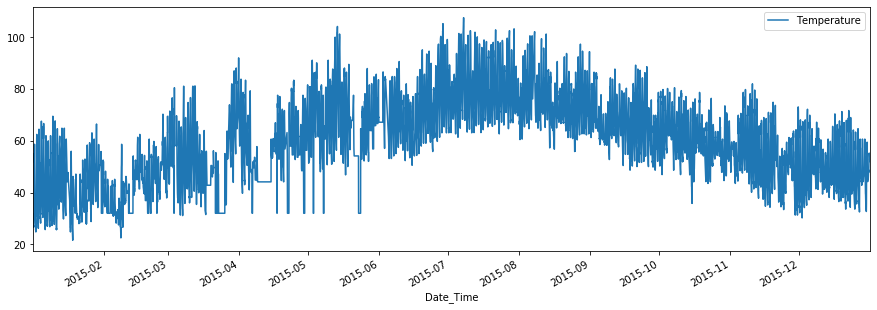

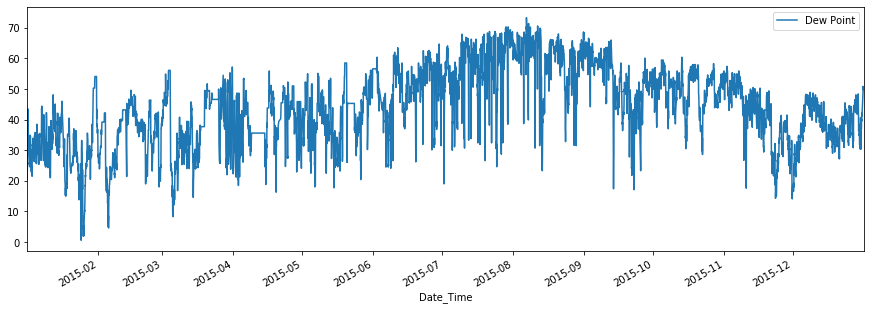

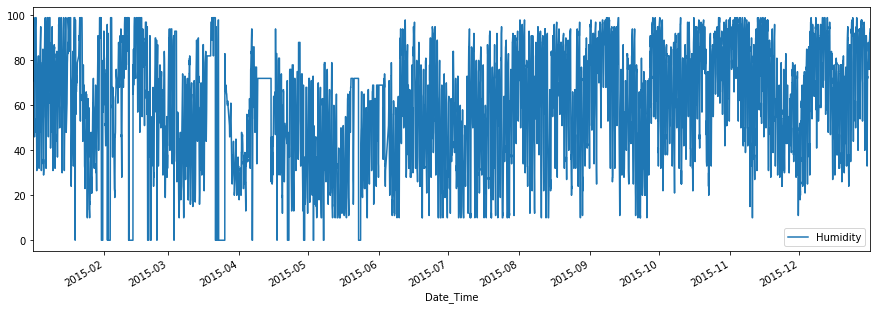

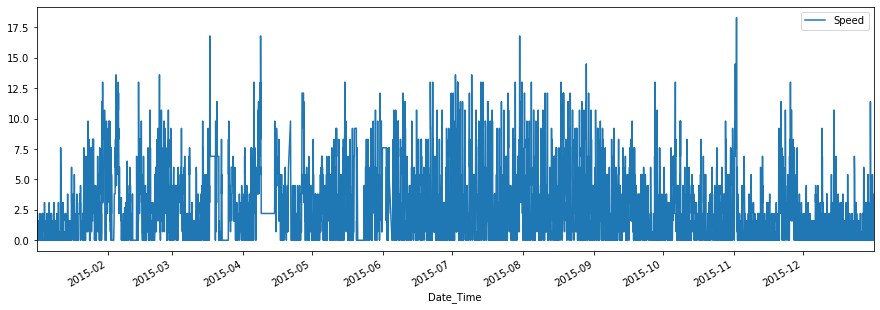

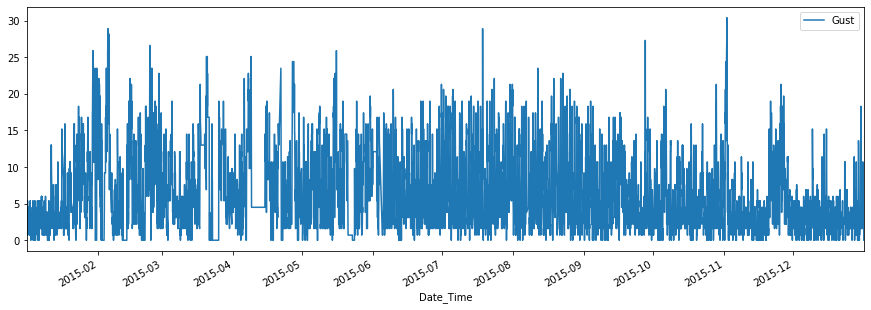

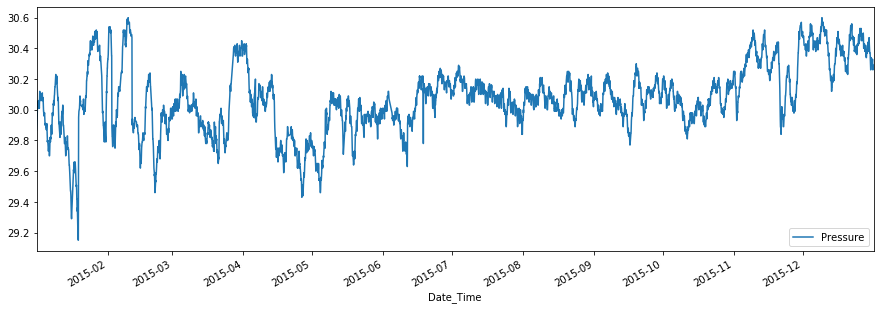

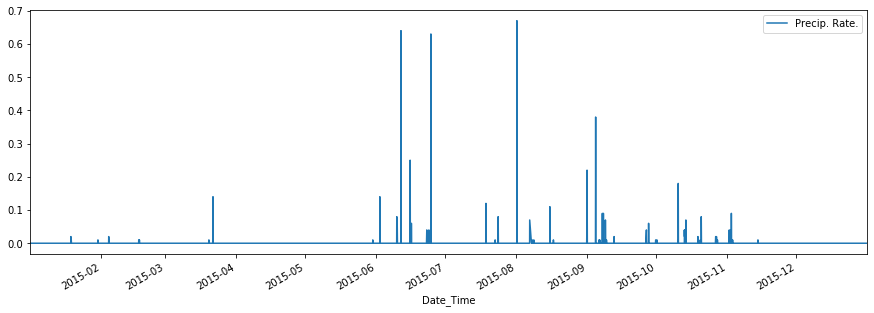

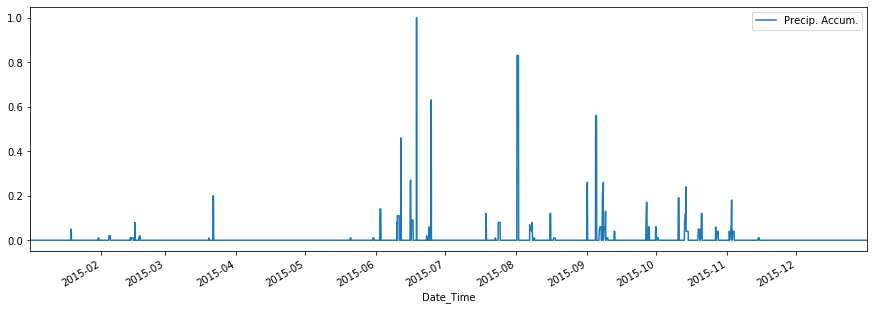

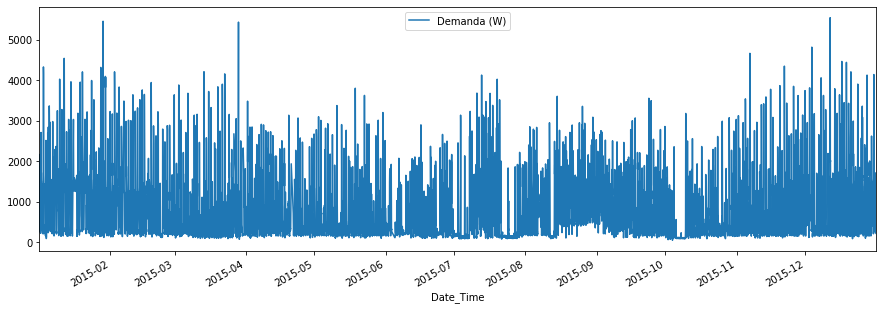

In [9]:
cols = df_demanda.columns.drop(['Date_Time', 'Hour', 'Day'])
df_demanda[cols] = df_demanda[cols].apply(pd.to_numeric)

for i in range(len(cols)):
    df_demanda.plot(x='Date_Time', y=df_demanda[cols].columns[[i]], figsize=(15,5))

## Predictions (Demanda (W)

<hr>
<ul>
    <li> Only two features are kept: 'Temperature' and 'Demanda (W)' as it can be shown that the results of including the rest are actually worst.</li>
    <li> These features are transformed with the <code>series_to_supervised()</code> function, <i>i.e.</i>, new features are engineered by lagging 'Temperature' and 'Demanda (W)'.</li>
    <li> In this notebook we focus on 3+1 hours: creating three lagged features for each variable and predicting the next hour-one.</li>
    <li> We split the data into train (80%) and test (20%) sets and shuffle them given that this improves the results. However a couple of notes are in order as mentioned <a href='https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/'> here</a>:</li>
        <ul>
            <li> <i>We do not want to shuffle inputs because all samples are sequential.</i></li>
            <li> <i>By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations</i>.</li>
        <\ul>
</ul>
<hr>

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE, r2_score
from pandas import DataFrame, concat
from numpy import concatenate
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb

Using TensorFlow backend.


<hr>

### Transform

<ul>
    <li> All columns are scaled and shifted according to the <code>series_to_supervised()</code> function. The shifted target column will also be a feature!
    <li> This dataframe is concatenated to the target.
</ul>
<hr>

In [31]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# values = df_demanda.drop(['Date_Time', 'Day'], axis=1).values
values = df_demanda[['Temperature', 'Demanda (W)']].values

n_features = values.shape[1]
n_hours = 3
n_out = 1

# frame as supervised learning
lagged = series_to_supervised(values[:, :], n_hours, n_out, True)  # .reset_index(drop=True)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(lagged.values)
scaled_df = pd.DataFrame(scaled, columns=lagged.columns)

reframed = pd.concat([scaled_df.iloc[:, :-1], pd.Series(scaled[:, -1], name='Demanda')], axis=1).dropna()
reframed.head()

print(reframed.shape)
reframed.head(10)

(8227, 8)


,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),Demanda
0,0.115385,0.039287,0.081585,0.047654,0.081585,0.165151,0.058275,0.250637
1,0.081585,0.047654,0.081585,0.165151,0.058275,0.250637,0.066434,0.245726
2,0.081585,0.165151,0.058275,0.250637,0.066434,0.245726,0.058275,0.239724
3,0.058275,0.250637,0.066434,0.245726,0.058275,0.239724,0.068765,0.242270
4,0.066434,0.245726,0.058275,0.239724,0.068765,0.242270,0.068765,0.272645
5,0.058275,0.239724,0.068765,0.242270,0.068765,0.272645,0.079254,0.385959
6,0.068765,0.242270,0.068765,0.272645,0.079254,0.385959,0.123543,0.182066
7,0.068765,0.272645,0.079254,0.385959,0.123543,0.182066,0.268065,0.292834
8,0.079254,0.385959,0.123543,0.182066,0.268065,0.292834,0.389277,0.267370
9,0.123543,0.182066,0.268065,0.292834,0.389277,0.267370,0.351981,0.223354


<hr>

### Split in train and test sets
<ul>
    <li> The data are shuffled.
    <li> We take 80% of the dataset for training.
    <li> X_train and _test sets contain only lagged data&mdash;no var(t).
</ul>
<hr>

In [32]:
shuffled_vals = True

# shuffle data
idx = np.arange(reframed.shape[0])
np.random.shuffle(idx)

if shuffled_vals:
    values = reframed.values[idx]
else: values = reframed.values

# split into train and test sets (80%)
n_train_hours = int(reframed.shape[0] * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Total set of (lagged) features
n_obs = n_hours * n_features

# split into input and outputs
X_train, y_train = train[:, :n_obs], train[:, -1]
X_test, y_test = test[:, :n_obs], test[:, -1]
print(X_train.shape, y_train.shape)

# reshape input to be 3D [samples, timesteps, features]
X_train_in = X_train.reshape((X_train.shape[0], n_hours, n_features))#X_train.shape[1]))
X_test_in = X_test.reshape((X_test.shape[0], n_hours, n_features))#X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6581, 6) (6581,)
(6581, 6) (6581,) (1646, 6) (1646,)


<hr>

### LSTM Net

Test loss: 0.057128171838213435
Test mean squared error: 0.009522849693894386


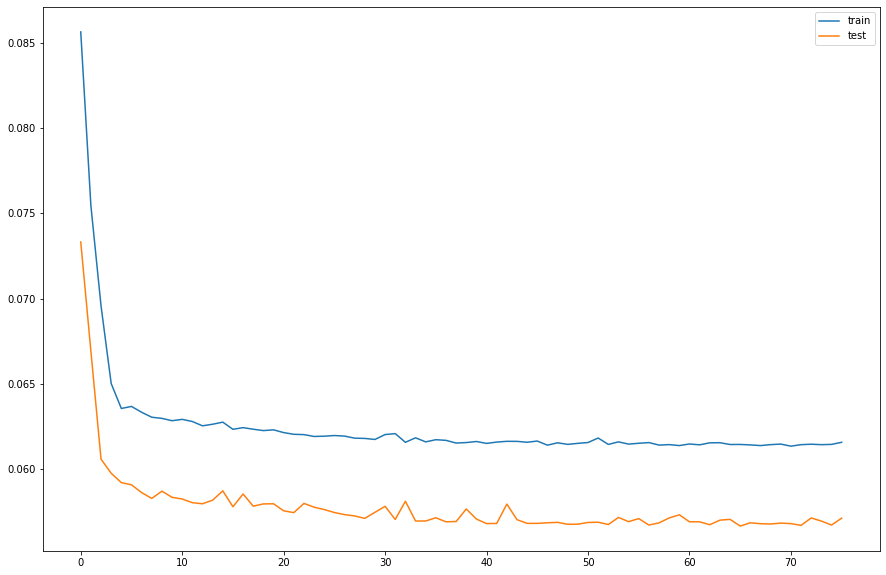

In [33]:
def fit_network(n_neurons=50, n_outputs=n_out,
                optimizer='adam', batch_size=72, epochs=100, verbosity=2, shuffled=False):
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(X_train_in.shape[1], X_train_in.shape[2])))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

    # Run network
    history = model.fit(X_train_in, y_train, epochs=100, batch_size=batch_size, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                        #validation_split=0.1, 
                        validation_data=(X_test_in, y_test),
                        verbose=verbosity, shuffle=shuffled)
    
    return (model, history)

model, history = fit_network(shuffled=True, verbosity=0)

loss, mse = model.evaluate(X_test_in, y_test, verbose=0)
print('Test loss:', loss)
print('Test mean squared error:', mse)

# plot history
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<hr>

### Predictions
<ul>
    <li> y_pred_out and y_test are concatenated to a full set of features&mdash;var(t-1), in this case&mdash;in order to perform the inverse scaling only.
    <li> Then we calculate the RMSE, model accuracy and the <a href='https://en.wikipedia.org/wiki/Mean_directional_accuracy'>mean directional accuracy</a>.
</ul>
<hr>

In [34]:
y_pred_out = model.predict(X_test_in)

#======================================================= inverting
def inverting(series, ls=-1):
    x = scaler.inverse_transform(concatenate((test[:, :ls], series), axis=1))[:, -n_out:]
    return x

y_pred = inverting(y_pred_out)
y_inv = inverting(y_test.reshape(y_test.shape[0], 1))
#=======================================================


#======================================================= metrics
# calculate RMSE
rmse = sqrt(MSE(y_inv, y_pred))
print('Test RMSE: %.3f' % rmse)

# calculate model accuracy
LSTM_accuracy = r2_score(y_inv, y_pred)
print('Model accuracy: {:.3f}'.format(LSTM_accuracy))

# calculate mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) 
                    == np.sign(predicted[1:] - predicted[:-1])).astype(int))

print('Model Mean Directional accuracy: {:.3f}'.format(mda(y_inv, y_pred)))

Test RMSE: 536.523
Model accuracy: 0.474
Model Mean Directional accuracy: 0.778


<hr>
The following plots show:
<ol>
  <li>The full y_test set and the predictions, ordered in time (remember that this is a random-shuffling sample).
  <li> The same y_test and predictions of only the last 150 data points.
  <li> The full dataset and its prediction for only the first (ordered) pnts=800 data points. This one should be taken carefully as points used for training the model were used for predicting.
</ol>
<hr>

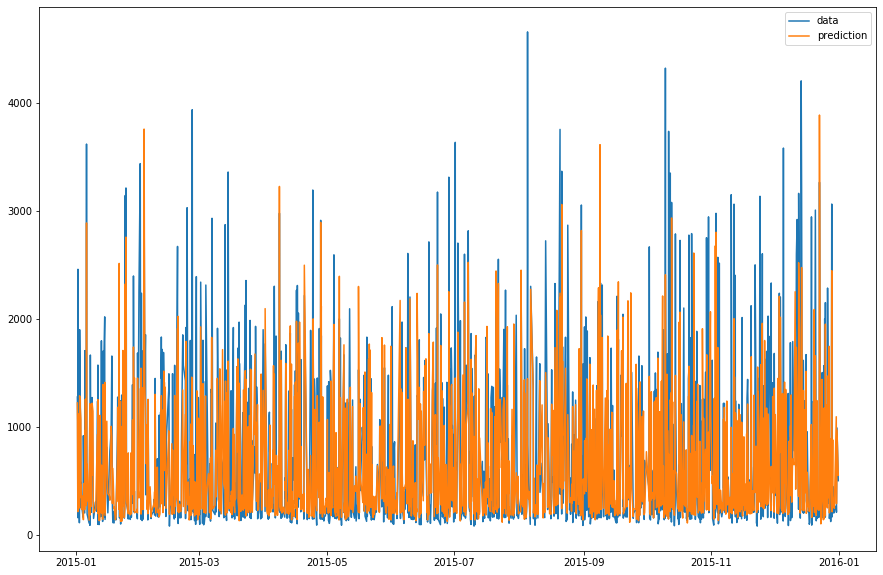

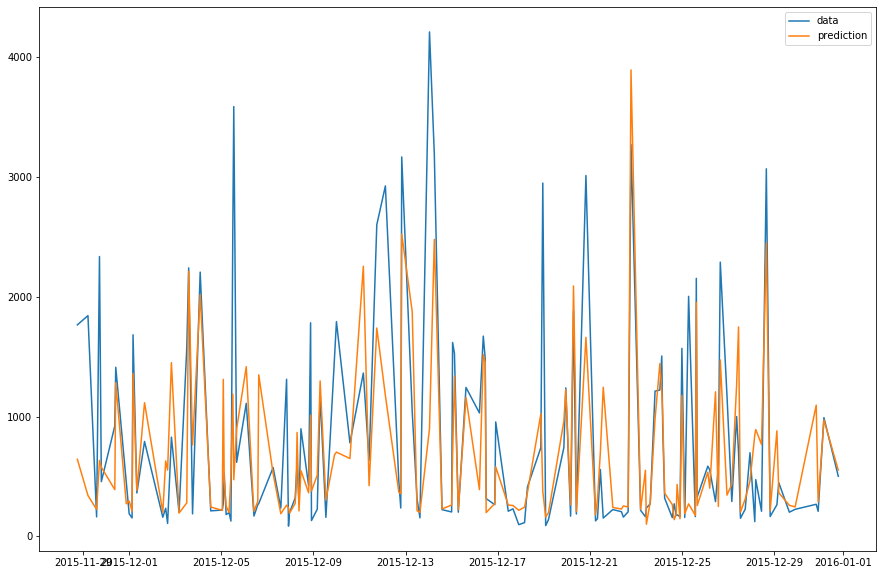

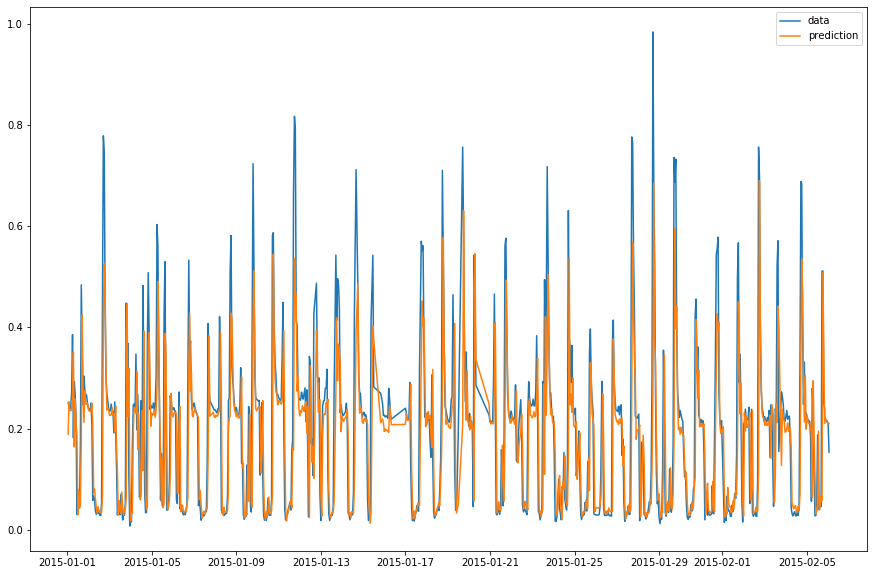

In [35]:
#======================================================= plot predictions

hours_df = df_demanda.Date_Time[idx].iloc[n_train_hours:].sort_values()

plt.figure(figsize=(15, 10))
plt.plot(hours_df, y_inv, label='data')
plt.plot(hours_df, y_pred, label='prediction')
plt.legend()
# plt.savefig('predvsdata.pdf')

plt.figure(figsize=(15, 10))
plt.plot(hours_df[-150:], y_inv[-150:], label='data')
plt.plot(hours_df[-150:], y_pred[-150:], label='prediction')
plt.legend()

rf = reframed.iloc[:, :n_obs].values
rf_rs = rf.reshape((rf.shape[0], n_hours, n_features))
y_pred_full = model.predict(rf_rs)
#
pnts = 800
plt.figure(figsize=(15, 10))
plt.plot(df_demanda.Date_Time[:pnts], reframed.iloc[:pnts, -1], label='data')
plt.plot(df_demanda.Date_Time[:pnts], y_pred_full[:pnts], label='prediction')
plt.legend()

<hr>
Next, we <b>repeat the experiment 30 times</b> to obtain statistics of the metrics.
<hr>

100%|██████████| 31/31 [11:38<00:00, 22.53s/it]


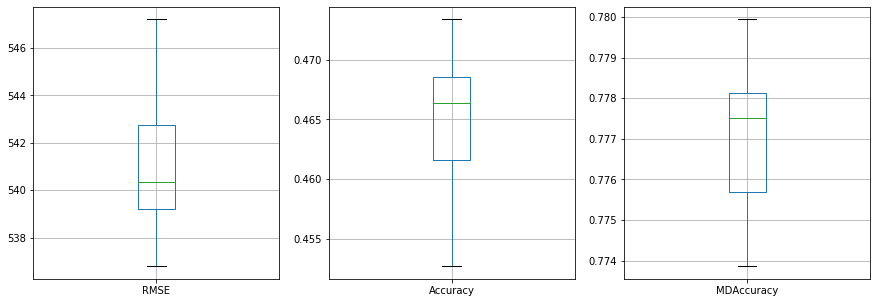

In [36]:
def lstm_net(X_train_in, y_train, X_test_in, y_test, X_test):
    
    model, history = fit_network(verbosity=0, shuffled=True)
    y_pred_out = model.predict(X_test_in)

    # invert scaling for forecast and actual
    y_pred = inverting(y_pred_out)
    y_inv = inverting(y_test.reshape(y_test.shape[0], 1))

    # metrics
    rmse = sqrt(MSE(y_inv, y_pred))
    LSTM_accuracy = r2_score(y_inv, y_pred)
    mean_da = mda(y_inv, y_pred)
    
    return (rmse, y_inv, y_pred, LSTM_accuracy, mean_da)

import time
from tqdm import tqdm
    
rmse_l, y_inv_l, y_pred_l, acc_l, mda_l = [], [], [], [], []
for i in tqdm(range(31)):
    tqdm._instances.clear()
    
    rmse, y_inv, y_pred, acc, mdacc = lstm_net(X_train_in, y_train, X_test_in, y_test, X_test)
    
    rmse_l.append(rmse)
    y_inv_l.append(y_inv)
    y_pred_l.append(y_pred)
    acc_l.append(acc)
    mda_l.append(mdacc)
    
# getting the index of the median rmse value and extract the predictions of this value
rsme_df = pd.DataFrame(rmse_l)
rsme_med = pd.DataFrame(rmse_l).median().values[0]
ind_med = rsme_df[rsme_df[0]==rsme_med].index.tolist()[0]
y_pred_lstm = y_pred_l[ind_med]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
pd.DataFrame(rmse_l, columns=['RMSE']).boxplot(figsize=(7,6), ax=ax[0])
pd.DataFrame(acc_l, columns=['Accuracy']).boxplot(figsize=(7,6), ax=ax[1])
pd.DataFrame(mda_l, columns=['MDAccuracy']).boxplot(figsize=(7,6), ax=ax[2])
# plt.savefig('RMSE.pdf')

<hr>

## XGBOOST

We now use an <i>Extreme Gradient Boosting</i> model to make predictions. In this case we will use the full dataset (with no lagged features) and only perform a normalization. We again allow shuffling.
<hr>

In [17]:
values = df_demanda.drop(['Date_Time', 'Day'], axis=1).values
#values = df_demanda[['Temperature', 'Demanda (W)']].values

n_features = values.shape[1]
n_hours = 1
n_out = 1

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = pd.DataFrame(scaled, columns=df_demanda.drop(['Date_Time', 'Day'], axis=1).columns)
#reframed = df_demanda.drop(['Date_Time', 'Day'], axis=1)

print(reframed.shape)

# split into train and test sets
if shuffled_vals:
    values = reframed.values[idx]
else: values = reframed.values
    
n_train_hours = int(reframed.shape[0] * 0.8) #(2/3))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_obs = n_hours * (n_features-1)

X_train, y_train = train[:, :n_obs], train[:, -1]
X_test, y_test = test[:, :n_obs], test[:, -1]
print(X_train.shape, y_train.shape)
reframed.head(10)

(8230, 10)
(6584, 9) (6584,)


,Temperature,Dew Point,Humidity,Speed,Gust,Pressure,Precip. Rate.,Precip. Accum.,Hour,Demanda (W)
0,0.115385,0.310867,0.717172,0.000000,0.072368,0.496552,0.0,0.0,0.043478,0.039287
1,0.081585,0.290234,0.757576,0.000000,0.052632,0.503448,0.0,0.0,0.086957,0.047654
2,0.081585,0.298487,0.777778,0.000000,0.072368,0.510345,0.0,0.0,0.130435,0.165151
3,0.058275,0.272352,0.777778,0.000000,0.052632,0.524138,0.0,0.0,0.173913,0.250637
4,0.066434,0.290234,0.797980,0.000000,0.023026,0.531034,0.0,0.0,0.217391,0.245726
5,0.058275,0.288858,0.818182,0.038251,0.072368,0.544828,0.0,0.0,0.260870,0.239724
6,0.068765,0.338377,0.919192,0.120219,0.177632,0.558621,0.0,0.0,0.304348,0.242270
7,0.068765,0.367263,1.000000,0.000000,0.052632,0.572414,0.0,0.0,0.347826,0.272645
8,0.079254,0.379642,1.000000,0.038251,0.101974,0.579310,0.0,0.0,0.391304,0.385959
9,0.123543,0.430536,1.000000,0.120219,0.125000,0.600000,0.0,0.0,0.434783,0.182066


<hr>
We construct a <code>GridSearchCV()</code> object to obtain a set of beast hyperparameters. Then we compute the metrics for this model.
<hr>

In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

def xgb_reg(X_train, y_train, X_test, y_test):

    '''# ==================================================== simple regressor
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.1,
                    max_depth = 20, alpha = 10, n_estimators = 100)

    xg_reg.fit(X_train, y_train, eval_metric="mae", eval_set=[(X_train, y_train), (X_test, y_test)], 
               verbose=False, early_stopping_rounds = 10)

    y_pred_xg = xg_reg.predict(X_test)'''
    
    # ==================================================== grid
    dmatrix = xgb.DMatrix(data=X_train,label=y_train) 
    xg_param_grid = {'learning_rate': [0.1, 0.3, 0.5], 
                      'n_estimators': [50, 100, 200], 
                      'max_depth': [10, 20, 30],
                      'alpha': [0, 10],
                      'subsample': [0.3, 0.5, 0.9],
                      'colsample_bytree': [0.8,1]
                     } 
    
    xg = xgb.XGBRegressor(objective ='reg:squarederror')
    
    grid_rmse = GridSearchCV(estimator=xg, param_grid=xg_param_grid, 
                            scoring='neg_mean_squared_error', cv=4, verbose=1)
    
    grid_rmse.fit(X_train, y_train, eval_metric="mae", eval_set=[(X_train, y_train), (X_test, y_test)], 
                  verbose=False, early_stopping_rounds = 10)
    
    y_pred_xg = grid_rmse.predict(X_test)
    
    # ==================================================== inverting
    def inverting(series):
        x = scaler.inverse_transform(concatenate((X_test[:, -n_features:], series), axis=1))[:, -1]
        return x
    
    y_pred_xg = inverting(y_pred_xg.reshape(y_pred_xg.shape[0], 1))
    y_inv = inverting(y_test.reshape(y_test.shape[0], 1))

    # ==================================================== metrics
    rmse = sqrt(MSE(y_inv, y_pred_xg))
    accuracy = r2_score(y_inv, y_pred_xg)
    mean_da = mda(y_inv, y_pred_xg)
    
    print("Best parameters found: ", grid_rmse.best_params_) 
    print("Lowest RMSE found: ", np.sqrt(np.abs(grid_rmse.best_score_)))
    
    return (rmse, accuracy, mean_da, y_pred_xg, y_inv)


rmse_xgb, acc_xgb, mda_xgb, y_pred_xgb, y_inv_xgb = xgb_reg(X_train, y_train, X_test, y_test)
    
print('Test set RMSE of xg: {:.4f}'.format(rmse_xgb))
print('Test set score of xg: {:.4f}'.format(acc_xgb))
print('Model Mean Directional accuracy: {:.3f}'.format(mda_xgb))

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed: 15.0min finished


Best parameters found:  {'alpha': 0, 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.5}
Lowest RMSE found:  0.10995880019316938
Test set RMSE of xg: 614.6687
Test set score of xg: 0.3940
Model Mean Directional accuracy: 0.713


<hr>
Here we plot the predictions for the last 150 data points (same as figure 2 of LSTM).
<hr>

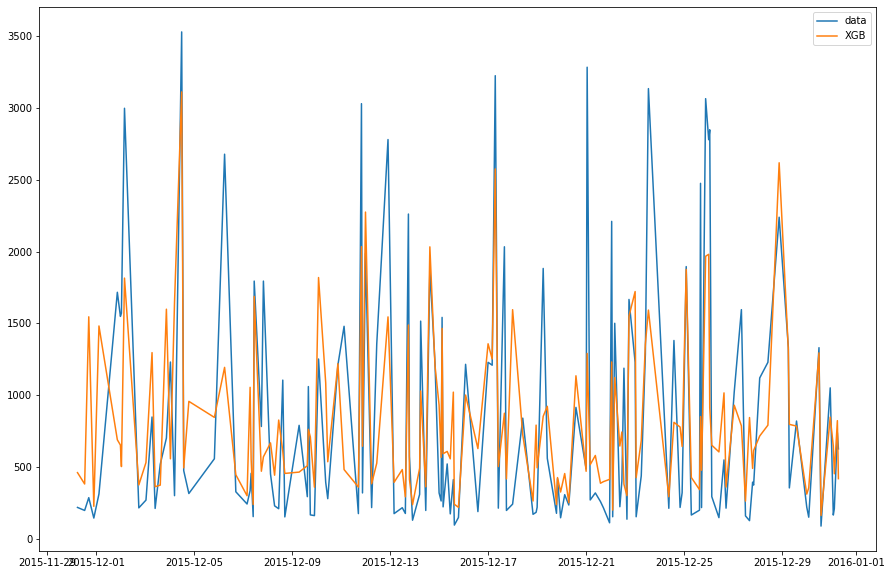

In [19]:
# plot history
plt.figure(figsize=(15, 10))
plt.plot(hours_df[-150:], y_inv_xgb[-150:], label='data')
plt.plot(hours_df[-150:], y_pred_xgb[-150:], label='XGB')
plt.legend()
# plt.savefig('predvsdata.pdf')
plt.show()